# MDB Box Office Prediction 

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/10300/logos/thumb76_76.png?t=2019-02-05-19-29-15)

https://kaggle.com/c/tmdb-box-office-prediction

In [216]:
import pandas as pd
import numpy as np
import os
import seaborn as sns 
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p,inv_boxcox1p,boxcox
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import catboost as catb
import operator
import time
import ast
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [217]:
print(os.listdir('Data/'))
path = 'Data/'

['sample_submission.csv', 'test.csv', 'train.csv']


Import data

In [218]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [219]:
print(train.shape + test.shape)

(3000, 23, 4398, 22)


Elements null for each column

In [220]:
train.isnull().sum(axis = 0)

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

## Data overview & Feature Engineering

In [221]:
pd.set_option("display.max_columns",100)
train.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [222]:
train.dropna().shape

(203, 23)

In [223]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

We begin to set the distribution of ```budget```.

In [224]:
#train['budget'] = np.log10(train['budget'])
#test['budget'] = np.log10(test['budget'])

### Fix features 

#### Runtime

In [225]:
train[train.runtime == 0].shape

(12, 23)

In [226]:
test[test.runtime == 0].shape

(9, 22)

### CLEAN

In [227]:
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture

In [228]:
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

In [229]:
# TRAIN 

train.runtime[train.id == 391] = 86 #Il peor natagle de la meva vida
train.runtime[train.id == 592] = 90 #А поутру они проснулись
train.runtime[train.id == 925] = 95 #¿Quién mató a Bambi?
train.runtime[train.id == 978] = 93 #La peggior settimana della mia vita
train.runtime[train.id == 1256] = 92 #Cipolla Colt
train.runtime[train.id == 1542] = 93 #Все и сразу
train.runtime[train.id == 1875] = 86 #Vermist
train.runtime[train.id == 2151] = 108 #Mechenosets
train.runtime[train.id == 2499] = 108 #Na Igre 2. Novyy Uroven
train.runtime[train.id == 2646] = 98 #同桌的妳
train.runtime[train.id == 2786] = 111 #Revelation
train.runtime[train.id == 2866] = 96 #Tutto tutto niente niente

# TEST
test.runtime[test.id == 4074] = 103 #Shikshanachya Aaicha Gho
test.runtime[test.id == 4222] = 93 #Street Knight
test.runtime[test.id == 4431] = 100 #Плюс один
test.runtime[test.id == 5520] = 86 #Glukhar v kino
test.runtime[test.id == 5845] = 83 #Frau Müller muss weg!
test.runtime[test.id == 5849] = 140 #Shabd
test.runtime[test.id == 6210] = 104 #Le dernier souffle
test.runtime[test.id == 6804] = 145 #Chaahat Ek Nasha..
test.runtime[test.id == 7321] = 87 #El truco del manco

In [230]:
train[train.runtime == 0].shape

(0, 23)

In [231]:
test[test.runtime == 0].shape

(0, 22)

In [232]:
power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

We are working with a wide range of revenue values so we will need to aproximate it to a normal distribution in order that the data can be more moldable

In [233]:
def visualize_distribution(y):
    sns.distplot(y,fit=norm)
    mu,sigma=norm.fit(y)
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of revenue")
    plt.ylabel("Frequency")
    plt.show()
    
    
def visualize_probplot(y):
    stats.probplot(y,plot=plt)
    plt.show()

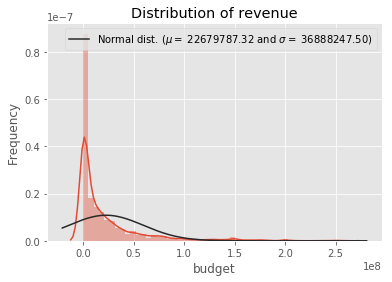

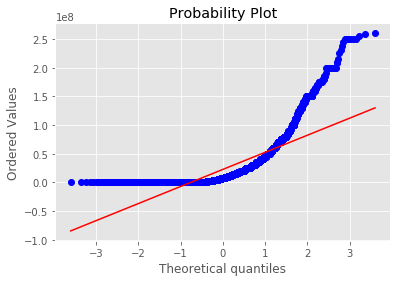

In [234]:
visualize_distribution(test.budget)
visualize_probplot(test.budget)

It turns out that the boxcox transformation with **coefficient 0.2** is the one which makes the probability plot closer to linear: we thus apply it to y_train.

In [235]:
train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])

train['popularity'] = np.log1p(train['popularity'])
test['popularity'] = np.log1p(test['popularity'])

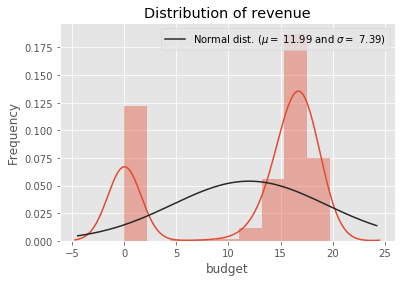

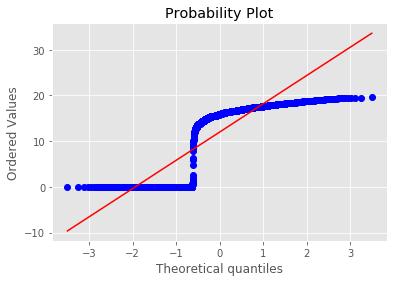

In [236]:
visualize_distribution(train.budget)
visualize_probplot(train.budget)

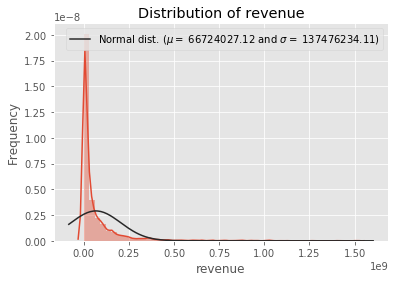

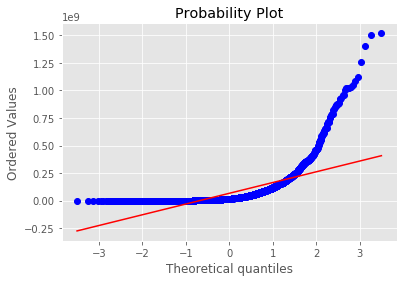

In [237]:
visualize_distribution(train.revenue)
visualize_probplot(train.revenue)

**After getting the prediction we must perform the inverse operation**

Useless Features

We drop some of the features that are not useful (at first glance)

* imdb_id : if we stick to the data that is provided, we don't need this id. Perhaps we could add some new external data with it later...
* poster_path : a link to the poster picture (no need for now, if we want to use some ensemble techniques)

In [238]:
train = train.drop(['imdb_id', 'poster_path'], axis = 1)
test = test.drop(['imdb_id', 'poster_path'], axis = 1)

### Cast & Crew

In [240]:
train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
train.loc[train["crew"].notnull(),"crew"]=train.loc[train["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
test.loc[test["crew"].notnull(),"crew"]=test.loc[test["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

ValueError: malformed node or string: [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character': 'Jill', 'credit_id': '52fe4ee7c3a36847f82afafb', 'gender': 1, 'id': 94098, 'name': 'Gillian Jacobs', 'order': 5, 'profile_path': '/rBnhe5vhNPnhRUdtYahBWx90fJM.jpg'}, {'cast_id': 10, 'character': 'Sophie', 'credit_id': '52fe4ee7c3a36847f82afaff', 'gender': 1, 'id': 1159009, 'name': 'Bianca Haase', 'order': 6, 'profile_path': '/4x3nbtD8q8phAJPmoGWXPvz0iM.jpg'}, {'cast_id': 11, 'character': 'Kelly', 'credit_id': '5524ec51c3a3687df3000dbb', 'gender': 1, 'id': 86624, 'name': 'Collette Wolfe', 'order': 7, 'profile_path': '/aSD4h5379b2eEw3bLou9ByLimmq.jpg'}, {'cast_id': 13, 'character': 'Brad', 'credit_id': '5524ec8ec3a3687ded000d72', 'gender': 2, 'id': 466505, 'name': 'Kumail Nanjiani', 'order': 9, 'profile_path': '/x4nAztHY72SVciRfxEsbhIVTsIu.jpg'}, {'cast_id': 14, 'character': 'Courtney', 'credit_id': '5524ec9bc3a3687df8000d13', 'gender': 1, 'id': 70776, 'name': 'Kellee Stewart', 'order': 10, 'profile_path': '/w3xmsEPmJc1Cf0dQ4aIn8YmlHbk.jpg'}, {'cast_id': 15, 'character': 'Terry', 'credit_id': '5524eca892514171cb008237', 'gender': 2, 'id': 347335, 'name': 'Josh Heald', 'order': 11, 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'cast_id': 16, 'character': 'Susan', 'credit_id': '5524ecb7925141720c001116', 'gender': 0, 'id': 1451392, 'name': 'Gretchen Koerner', 'order': 12, 'profile_path': '/muULPexCTJGyJba4yKzxronpD50.jpg'}, {'cast_id': 17, 'character': 'Herself', 'credit_id': '5524ecc3c3a3687ded000d74', 'gender': 1, 'id': 98879, 'name': 'Lisa Loeb', 'order': 13, 'profile_path': '/bGqg58ca0bZR38z9HliUMmeNGE.jpg'}, {'cast_id': 18, 'character': 'Herself', 'credit_id': '5524ecd3c3a3687e11000ed3', 'gender': 1, 'id': 1394648, 'name': 'Jessica Williams', 'order': 14, 'profile_path': '/A4syKjkcYB92wLEhH0c0hC3BCpz.jpg'}, {'cast_id': 19, 'character': 'Himself', 'credit_id': '5524ece6925141718d001009', 'gender': 0, 'id': 1451393, 'name': 'Bruce Buffer', 'order': 15, 'profile_path': None}, {'cast_id': 20, 'character': 'Shot Girl', 'credit_id': '5524ecf5c3a3687e08000dc2', 'gender': 0, 'id': 1451394, 'name': 'Mariana Paola Vicente', 'order': 16, 'profile_path': '/ckPllza8624UHWGHCbLShkLxCD1.jpg'}, {'cast_id': 33, 'character': 'Choozy Doozy Host', 'credit_id': '555844da9251412afe0013a9', 'gender': 2, 'id': 2224, 'name': 'Christian Slater', 'order': 17, 'profile_path': '/3ElLWjnvchMS6Q4cIQOK8QNAoMG.jpg'}, {'cast_id': 35, 'character': 'Gary Winkle', 'credit_id': '55872027c3a3683853005074', 'gender': 0, 'id': 185805, 'name': 'Jason Jones', 'order': 18, 'profile_path': '/aIoCw6vo8AGMdsQRAI5g2t0yJT3.jpg'}, {'cast_id': 36, 'character': 'Bridesmaid', 'credit_id': '55efe971c3a368090c00cd1b', 'gender': 0, 'id': 1507448, 'name': 'Olivia Jordan', 'order': 19, 'profile_path': '/szMukAEiIDeasel0lvyaeyKuych.jpg'}, {'cast_id': 37, 'character': 'Christine', 'credit_id': '55efe980c3a36871bf008176', 'gender': 1, 'id': 1334091, 'name': 'Christine Bently', 'order': 20, 'profile_path': '/oUZltnGa55OXE52hfyPTfCshuNy.jpg'}, {'cast_id': 38, 'character': 'Excited Girl', 'credit_id': '55efe98e9251413e3201d316', 'gender': 0, 'id': 557803, 'name': 'Stacey Asaro', 'order': 21, 'profile_path': '/qTPdlr1dXf3kNdyHuDsgtGC0HCC.jpg'}, {'cast_id': 64, 'character': 'Adam (uncredited)', 'credit_id': '58f2135ac3a3682e95008b91', 'gender': 2, 'id': 3036, 'name': 'John Cusack', 'order': 22, 'profile_path': '/uKydQYuZ9TnCzvbQLtj6j98vWAT.jpg'}, {'cast_id': 65, 'character': 'J-Bird', 'credit_id': '59ac0240c3a3682cc802c399', 'gender': 2, 'id': 59256, 'name': 'Adam Herschman', 'order': 23, 'profile_path': '/wZMwiuX1DslF6hDS50z9OTN6z1X.jpg'}, {'cast_id': 66, 'character': 'Bridesmaid', 'credit_id': '59ac02cd925141079d02b1b4', 'gender': 1, 'id': 129714, 'name': 'Kisha Sierra', 'order': 24, 'profile_path': None}]

In [241]:
train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6]) 

test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6]) 

In [242]:
def get_DirProdExP(df):
    df["Director"]=[[] for i in range(df.shape[0])]
    df["Producer"]=[[] for i in range(df.shape[0])]
    df["Executive Producer"]=[[] for i in range(df.shape[0])]

    df["Director"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])

    df["Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])

    df["Executive Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])
    
    return df

In [243]:
train = get_DirProdExP(train)
test = get_DirProdExP(test)

In [244]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Director,Producer,Executive Producer
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,"[{'id': 35, 'name': 'Comedy'}]",NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,[Steve Pink],[Andrew Panay],"[Rob Corddry, Ben Ormand, Matt Moore]"
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,[Garry Marshall],"[Whitney Houston, Mario Iscovich, Debra Martin...",[Ellen H. Schwartz]
2,3,NaN,15.009433,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,[Damien Chazelle],"[David Lancaster, Michel Litvak, Jason Blum, H...","[Jason Reitman, Gary Michael Walters, Jeanette..."
3,4,NaN,13.997833,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,[Sujoy Ghosh],[Sujoy Ghosh],[]
4,5,NaN,0.000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,ko,마린보이,Marine Boy is the story of a former national s...,0.764570,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,[Jong-seok Yoon],[],[]


### Quantitative features

Let's look at numbers first!
The quantitative features that could be helpful are:

* the budget
* the popularity
* the runtime
* and the target : revenue

In [24]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3000.000000,3.000000e+03,2998.000000,3.000000e+03
mean,1500.500000,11.985069,1.975396e+00,108.242161,6.672403e+07
std,866.169729,7.394925,7.416869e-01,21.020877,1.374992e+08
min,1.000000,0.000000,9.999995e-07,11.000000,1.000000e+00
25%,750.750000,0.000000,1.613042e+00,94.000000,2.447642e+06
50%,1500.500000,15.894952,2.125233e+00,104.000000,1.692863e+07
75%,2250.250000,17.216708,2.475780e+00,118.000000,6.877599e+07
max,3000.000000,19.755682,5.688117e+00,338.000000,1.519558e+09


First lets look how many NaN are on these data

In [25]:
print ('budget: ' + str(sum(train['budget'].isna())) + ', popularity: ' + str(sum(train['popularity'].isna())) + 
      ', runtime: ' + str(sum(train['runtime'].isna())) + ', revenue: ' + str(sum(train['revenue'].isna())))

budget: 0, popularity: 0, runtime: 2, revenue: 0


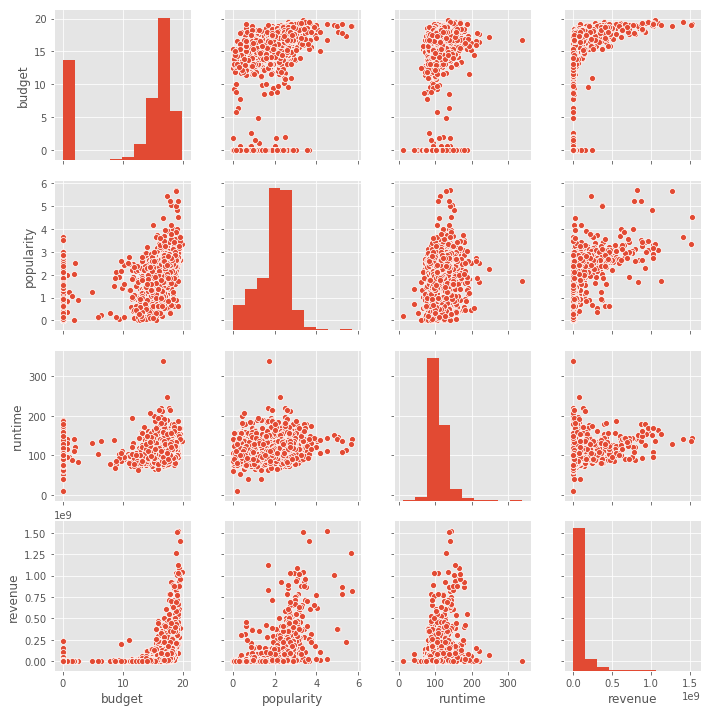

In [26]:
f = ['budget', 'popularity', 'runtime', 'revenue']
sns.pairplot(train[f].dropna())

At first look, the budget and the revenue seem correlated!

### Language

The spoken languages are contained in a list of dictionaries, represented by a string, let's symplify it.

In [27]:
print("raw format:", train['spoken_languages'].iloc[0])

train['spoken_languages'] = train['spoken_languages'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test['spoken_languages'] = test['spoken_languages'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

train.head().spoken_languages

raw format: [{'iso_639_1': 'en', 'name': 'English'}]


0        [en]
1        [en]
2        [en]
3    [en, hi]
4        [ko]
Name: spoken_languages, dtype: object

Now we can create 2 additional features: the number of spoken languages, and wheter the english belongs to them.

In [28]:
train['nb_spoken_languages'] = train.spoken_languages.apply(len)
test['nb_spoken_languages'] = test.spoken_languages.apply(len)

train['english_spoken'] = train.spoken_languages.apply(lambda x: 'en' in x)
test['english_spoken'] = test.spoken_languages.apply(lambda x: 'en' in x)

In [29]:
train['nb_spoken_languages'].value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: nb_spoken_languages, dtype: int64

There is one film in witch 9 languages are spoken ! Or maybe it is the number of languages in which the film has been translated...

**Original Language**

Let's see what are the principal main original languages in both train and test data :

In [30]:
all_languages = pd.concat([train.original_language, test.original_language], axis=0).value_counts()
all_languages[all_languages > 10]

en    6351
fr     199
hi     118
ru     109
es      95
ja      90
it      56
de      49
ko      49
zh      46
cn      41
ta      31
sv      20
da      17
pt      13
ml      12
nl      11
Name: original_language, dtype: int64

In [31]:
# Here are the main languages
main_languages = list(all_languages[all_languages>20].index)
# Let's categorize them, and add a 'other' catergorie
dict_language = dict(zip(main_languages, range(1, len(main_languages)+1)))
dict_language['other'] = 0

#keep only the languages that are on main_languages
train.original_language = train.original_language.apply(lambda x: x if x in main_languages else 'other')
test.original_language = test.original_language.apply(lambda x: x if x in main_languages else 'other')

#put languages to numeric according to the indexes of the dictionary
train['language'] = train.original_language.apply(lambda x: dict_language[x])
test['language'] = test.original_language.apply(lambda x: dict_language[x])

### Movie genre

Let's look at the different genres associated with the movies.

In [32]:
# Apply the same preprocessing on the string values
train.genres = train.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.genres = test.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

train.genres.head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres, dtype: object

Here is the distribution of the number of genres per movie. There are 3 films with 7 genres!

In [33]:
train.genres.apply(len).value_counts().sort_index()

0      7
1    593
2    972
3    900
4    393
5    111
6     21
7      3
Name: genres, dtype: int64

In [34]:
for v in train[train.genres.apply(len)==7][['title', 'genres']].values:
    print('film:', v[0], '\ngenres:', *v[1], '\n')

film: Jimmy Neutron: Boy Genius 
genres: Action Adventure Animation Comedy Family Fantasy Science Fiction 

film: Fishtales 
genres: Fantasy Drama Comedy Science Fiction Romance Family Foreign 

film: Crossroads 
genres: Action Adventure Comedy Drama Family Music Romance 



Frequency of all genres:

In [35]:
genres = Counter(itertools.chain.from_iterable(pd.concat((train.genres, test.genres), axis=0).values))
genres

Counter({'Comedy': 2605,
         'Drama': 3676,
         'Family': 675,
         'Romance': 1435,
         'Thriller': 1869,
         'Action': 1735,
         'Animation': 382,
         'Adventure': 1116,
         'Horror': 735,
         'Documentary': 221,
         'Music': 267,
         'Crime': 1084,
         'Science Fiction': 744,
         'Mystery': 550,
         'Foreign': 84,
         'Fantasy': 628,
         'War': 243,
         'Western': 117,
         'History': 295,
         'TV Movie': 1})

Instead of creating 20 categorical features, one for each genre, let's reduce those categories in a smaller space thanks to **SVD**.

In [36]:
%%time
temp_train = train[['id', 'genres']]
temp_test = test[['id', 'genres']]

for g in genres:
    temp_train[g] = temp_train.genres.apply(lambda x: 1 if g in x else 0)
    temp_test[g] = temp_test.genres.apply(lambda x: 1 if g in x else 0)
    
X_train = temp_train.drop(['genres', 'id'], axis=1).values
X_test = temp_test.drop(['genres', 'id'], axis=1).values

# Number of features we want for genres
n_comp_genres = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_genres),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

Wall time: 2.41 s


In [37]:
for i in range(n_comp_genres):
    train['genres_reduced_{}'.format(i)] = f_train[:, i]
    test['genres_reduced_{}'.format(i)] = f_test[:, i]

In [38]:
train[['genres_reduced_0', 'genres_reduced_1', 'genres_reduced_2']].head(3)

,genres_reduced_0,genres_reduced_1,genres_reduced_2
0,0.417619,-0.648865,0.636057
1,0.771957,-0.633633,0.050909
2,0.753463,-0.151677,-0.639756


### Keywords

In [39]:
train.Keywords = train.Keywords.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.Keywords = test.Keywords.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

In [40]:
train['nb_keywords'] = train.Keywords.apply(len)
test['nb_keywords'] = test.Keywords.apply(len)

### Production_companies 

In [41]:
train.production_companies = train.production_companies.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_companies = test.production_companies.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

In [42]:
production_companies = Counter(itertools.chain.from_iterable(pd.concat((train.production_companies, test.production_companies), axis=0).values))
print("Number of different production companies:", len(production_companies))

Number of different production companies: 7087


In [43]:
train['nb_production_companies'] = train.production_companies.apply(len)
test['nb_production_companies'] = test.production_companies.apply(len)

In [44]:
%%time
print('Applying SVD on production companies to create reduced features')

# Factorizing all the little production companies into an 'other' variable
big_companies = [p for p in production_companies if production_companies[p] > 30]
train.production_companies = train.production_companies.apply(lambda l: list(map(lambda x: x if x in big_companies else 'other', l)))

temp_train = train[['id', 'production_companies']]
temp_test = test[['id', 'production_companies']]

for p in big_companies + ['other']:
    temp_train[p] = temp_train.production_companies.apply(lambda x: 1 if p in x else 0)
    temp_test[p] = temp_test.production_companies.apply(lambda x: 1 if p in x else 0)
    
X_train = temp_train.drop(['production_companies', 'id'], axis=1).values
X_test = temp_test.drop(['production_companies', 'id'], axis=1).values

# Number of features we want for genres
n_comp_production_companies = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_production_companies),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

for i in range(n_comp_production_companies):
    train['production_companies_reduced_{}'.format(i)] = f_train[:, i]
    test['production_companies_reduced_{}'.format(i)] = f_test[:, i]

Applying SVD on production companies to create reduced features
Wall time: 2.67 s


### Production countries

In [45]:
train.production_countries = train.production_countries.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_countries = test.production_countries.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

In [46]:
production_countries = Counter(itertools.chain.from_iterable(pd.concat((train.production_countries, test.production_countries), axis=0).values))
print("Number of different production companies:", len(production_countries))

Number of different production companies: 98


In [47]:
%%time
print('Applying SVD on production countries to create reduced features')

# Factorizing all the little production companies into an 'other' variable
big_countries = [p for p in production_countries if production_countries[p] > 30]
train.production_countries = train.production_countries.apply(lambda l: list(map(lambda x: x if x in big_countries else 'other', l)))

temp_train = train[['id', 'production_countries']]
temp_test = test[['id', 'production_countries']]

for p in big_countries + ['other']:
    temp_train[p] = temp_train.production_countries.apply(lambda x: 1 if p in x else 0)
    temp_test[p] = temp_test.production_countries.apply(lambda x: 1 if p in x else 0)
    
X_train = temp_train.drop(['production_countries', 'id'], axis=1).values
X_test = temp_test.drop(['production_countries', 'id'], axis=1).values

# Number of features we want for genres
n_comp_production_countries = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_production_countries),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

for i in range(n_comp_production_countries):
    train['production_countries_reduced_{}'.format(i)] = f_train[:, i]
    test['production_countries_reduced_{}'.format(i)] = f_test[:, i]

Applying SVD on production countries to create reduced features
Wall time: 2.02 s


### Release Date

In [48]:
#Train
train['release_date'] = pd.to_datetime(train['release_date'])
train['Year'] = train.release_date.dt.year
train['Month'] = train.release_date.dt.month
train['Day'] = train.release_date.dt.day
train['dayofweek'] = train.release_date.dt.dayofweek 
train['quarter'] = train.release_date.dt.quarter   
#Test
test['release_date'] = pd.to_datetime(test['release_date'])
test['Year'] = test.release_date.dt.year
test['Month'] = test.release_date.dt.month
test['Day'] = test.release_date.dt.day
test['dayofweek'] = test.release_date.dt.dayofweek 
test['quarter'] = test.release_date.dt.quarter  

#### Dummy Month

In [49]:
dummies = pd.get_dummies(train['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(x))
dummies2 = pd.get_dummies(test['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(int(x)))
train = pd.concat([train, dummies], axis=1)
#train = train.drop(columns="Month")
test = pd.concat([test, dummies2], axis = 1)
#test = test.drop(columns="Month")

#### Dummy DayofWeek

In [50]:
ddow = pd.get_dummies(train['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(x))
ddow2 = pd.get_dummies(test['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(int(x)))
train = pd.concat([train, ddow], axis=1)
test = pd.concat([test, ddow2], axis = 1)

In [51]:
pd.set_option("display.max_columns", 200 )
train

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,nb_spoken_languages,english_spoken,language,genres_reduced_0,genres_reduced_1,genres_reduced_2,nb_keywords,nb_production_companies,production_companies_reduced_0,production_companies_reduced_1,production_companies_reduced_2,production_countries_reduced_0,production_countries_reduced_1,production_countries_reduced_2,Year,Month,Day,dayofweek,quarter,Month2,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12,dayofweek1,dayofweek2,dayofweek3,dayofweek4,dayofweek5,dayofweek6
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,[Comedy],NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,"[Paramount Pictures, United Artists, Metro-Gol...",[US],2015-02-20,93.0,[en],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,True,1,0.417619,-0.648865,0.636057,4,3,2.852111e-01,-0.272234,-0.918990,9.905814e-01,-0.136200,-0.014073,2015,2,20,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[Comedy, Drama, Family, Romance]",NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,[Walt Disney Pictures],[US],2004-08-06,113.0,[en],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1,True,1,0.771957,-0.633633,0.050909,4,1,6.211364e-01,-0.312476,-0.718713,9.905814e-01,-0.136200,-0.014073,2004,8,6,4,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,3,NaN,15.009433,[Drama],http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,"[other, Blumhouse Productions, other]",[US],2014-10-10,105.0,[en],Released,The road to greatness can take you to the edge.,Whiplash,"[jazz, obsession, conservatory, music teacher,...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,True,1,0.753463,-0.151677,-0.639756,12,3,9.980223e-01,-0.041275,-0.047412,9.905814e-01,-0.136200,-0.014073,2014,10,10,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,4,NaN,13.997833,"[Thriller, Drama]",http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,[],[IN],2012-03-09,122.0,"[en, hi]",Released,NaN,Kahaani,"[mystery, bollywood, police corruption, crime,...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,2,True,3,0.837641,0.319138,-0.443293,7,0,-1.027118e-05,-0.609030,0.793147,1.236946e-01,0.869540,0.478121,2012,3,9,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,5,NaN,0.000000,"[Action, Thriller]",NaN,ko,마린보이,Marine Boy is the story of a former national s...,0.764570,[],[KR],2009-02-05,118.0,[ko],Released,NaN,Marine Boy,[],"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,1,False,9,0.529907,0.766823,0.362189,0,0,5.125833e-06,-0.838416,0.545030,1.585112e-01,0.153162,0.975405,2009,2,5,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,6,NaN,15.894952,"[Animation, Adventure, Family]",NaN,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.555765,[],[],1987-08-06,83.0,[en],Released,NaN,Pinocchio and the Emperor of the Night,[],"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638,1,True,1,0.410912,-0.034941,0.911005,0,0,-3.936688e-07,0.536483,0.843911,-9

In [52]:
max(train.Year)
max(test.Year)

2068.0

The max Year can't be 2068!!

* After a paralell study of these cases we have found that all the dates > 2019 must start with 19XX

Lets fix it!!

In [53]:
sum(test.Year.isna())
sum(train.Year.isna())

0

We have to fix the NaT generated on test file

In [54]:
test.release_date[test.Year.isna()] = pd.to_datetime('2000-01-01')
test['Year'] = test.release_date.dt.year

In [55]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue', 'nb_spoken_languages', 'english_spoken',
       'language', 'genres_reduced_0', 'genres_reduced_1', 'genres_reduced_2',
       'nb_keywords', 'nb_production_companies',
       'production_companies_reduced_0', 'production_companies_reduced_1',
       'production_companies_reduced_2', 'production_countries_reduced_0',
       'production_countries_reduced_1', 'production_countries_reduced_2',
       'Year', 'Month', 'Day', 'dayofweek', 'quarter', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12', 'dayofweek1', 'dayofweek2', 'dayofweek3',
       'dayofweek4', 'dayofweek5', 'dayofweek6'],
     

In [56]:
#Train
train.release_date[train['Year'] > 2019.0] = train.release_date.apply(lambda x: x.strftime('%Y-%m-%d'))
train.Year[train['Year'] > 2019.0] = train.Year[train['Year'] > 2019].apply(str).str.replace('20', '19').apply(int)
#Test
test.release_date[test['Year'] > 2019.0] = test.release_date.apply(lambda x: x.strftime('%Y-%m-%d'))
test.Year[test['Year'] > 2019.0] = test.Year[test['Year'] > 2019].apply(str).str.replace('20', '19').apply(int)

In [57]:
train.Year.describe()

count    3000.000000
mean     1999.713000
std        15.423313
min      1921.000000
25%      1993.000000
50%      2004.000000
75%      2011.000000
max      2017.000000
Name: Year, dtype: float64

In [58]:
test.Year.describe()

count    4398.000000
mean     1999.675307
std        15.286695
min      1922.000000
25%      1992.000000
50%      2004.000000
75%      2011.000000
max      2018.000000
Name: Year, dtype: float64

### FilmAge

Difference in years from max(Year) - Year

In [59]:
train['FilmAge'] = max(train.Year) - train.Year
test['FilmAge'] = max(test.Year) - test.Year

### 21th Century Film??

We have observed that the 'effect 2000' is real in film escenario so lets create a feature to separe films in 3 groups:

    - BEFORE 1985
    - AFTER 1985 AND BEFORE 2000
    - AFTER 2000 AND BEFORE 2010
    - AFTER 2010

#### Year Distribution

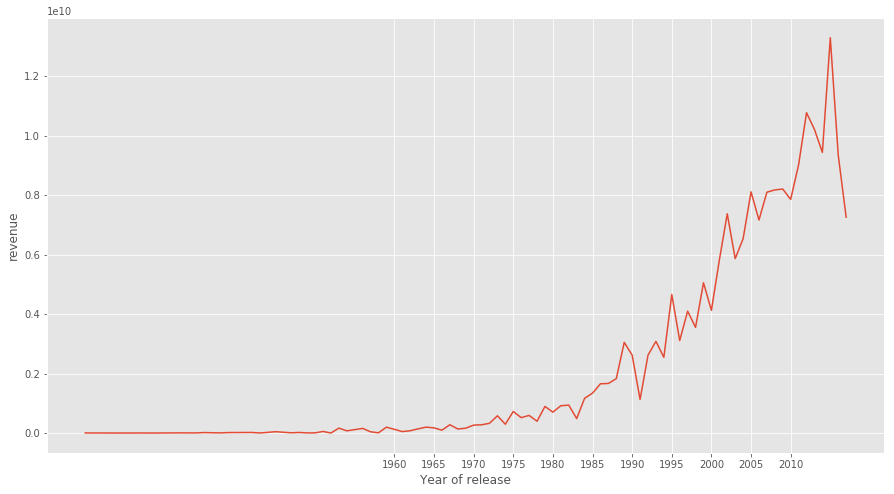

In [60]:
data_plot = train[['revenue', 'Year']]
money_Y = data_plot.groupby('Year')['revenue'].sum()
#money_M = data_plot.groupby('Month')['revenue'].sum()

money_Y.plot(figsize=(15,8))
plt.xlabel("Year of release")
plt.ylabel("revenue")
plt.xticks(np.arange(1960,2015,5))

#money_M.plot(figsize=(15,8))

plt.show()

#### Month Distribution

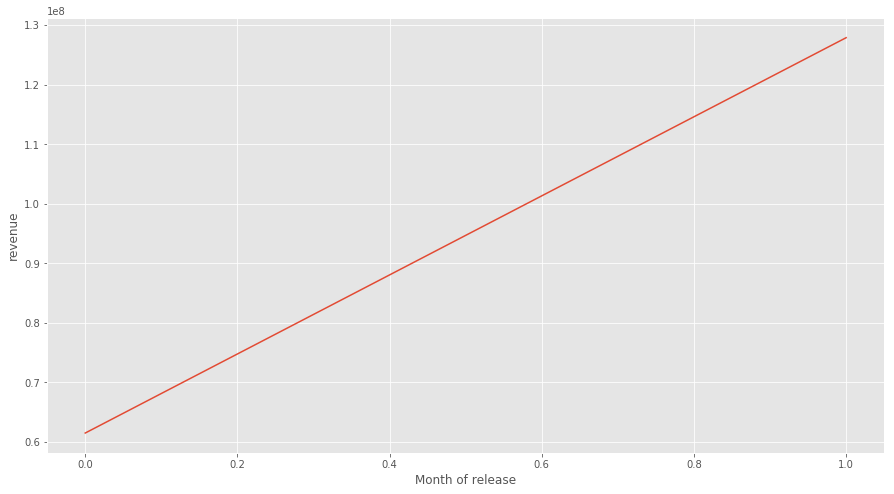

In [61]:
data_plot = train[['revenue', 'Month6']]
money_M = data_plot.groupby('Month6')['revenue'].mean()

money_M.plot(figsize=(15,8))
plt.xlabel("Month of release")
plt.ylabel("revenue")

plt.show()

#### Day of week Distribution

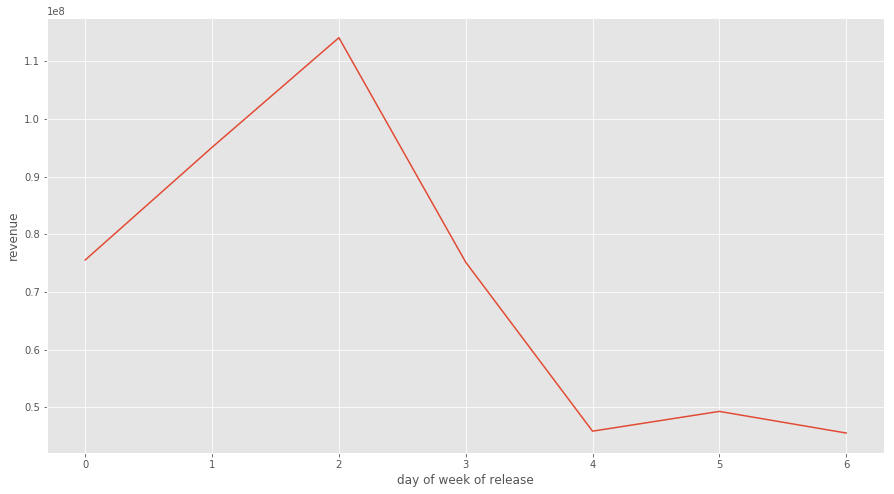

In [62]:
data_plot = train[['revenue', 'dayofweek']]
money_M = data_plot.groupby('dayofweek')['revenue'].mean()

money_M.plot(figsize=(15,8))
plt.xlabel("day of week of release")
plt.ylabel("revenue")

plt.show()

### Lazzy features

There are films which budget is 0, so we need to fix it, let's do it with the median that works fine avoiding outliers.

In [63]:
def lazzy_feat(df):
    df['crew_letter_count'] = df['crew'].str.len().fillna(0)
    df['crew_word_count'] = df['crew'].str.split().str.len().fillna(0)
    
    df['Ratiobudgetbypopularity'] = df['budget']/df['popularity']
    df['RatiopopularitybyYear'] = df['popularity']/df['Year']
    df['RatoioruntimebyYear'] = df['runtime']/df['Year']
    
    #df['meanruntimeByYear'] = df.groupby("Year")["runtime"].aggregate('mean')
    #df['meanPopularityByYear'] = df.groupby("Year")["popularity"].aggregate('mean')
    #df['meanBudgetByYear'] = df.groupby("Year")["budget"].aggregate('mean')
    
    #df['production_companies_letter_count'] = df['production_companies'].str.len().fillna(0)
    #df['production_companies_word_count'] = df['production_companies'].str.split().str.len().fillna(0)

    df['crew_letter_count'] = df['crew'].str.len().fillna(0)
    df['crew_word_count'] = df['crew'].str.split().str.len().fillna(0)
    
    return df

In [64]:
train = lazzy_feat(train)
test = lazzy_feat(test)

### Features from NAs Has Homepage

In [65]:
# NAs

train['has_homepage'] = np.where(train['homepage'].isna(), 0, 1)
train ['has_collection'] = np.where(train['belongs_to_collection'].isna(), 0, 1)

test['has_homepage'] = np.where(test['homepage'].isna(), 0, 1)
test ['has_collection'] = np.where(test['belongs_to_collection'].isna(), 0, 1)

train['has_tagline'] = np.where (train['tagline'].isna(), 0, 1)
test['has_tagline'] = np.where (test['tagline'].isna(), 0, 1)

#Fix Strange occurences

train['title_different'] = np.where(train['original_title'] == train['title'], 0, 1)
test['title_different'] = np.where(test['original_title'] == test['title'], 0, 1)

train['isReleased'] = np.where(train['status'] != 'Released', 0, 1)
test['isReleased'] = np.where(test['status'] != 'Released', 0, 1)


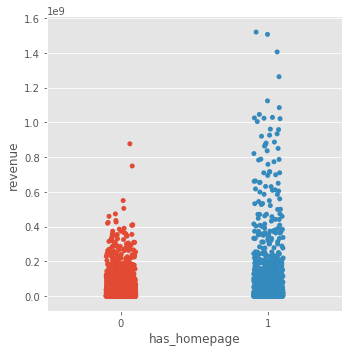

In [66]:
sns.catplot(x='has_homepage', y='revenue', data=train)

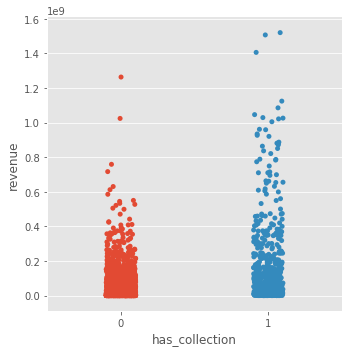

In [67]:
sns.catplot(x='has_collection', y='revenue', data=train)

### Models

In [104]:
features = ['budget', 
            'popularity', 
            'runtime', 
            'nb_spoken_languages', 
            'nb_production_companies',
            'english_spoken', 
            'language',
            'FilmAge',
            'has_homepage', 'has_collection', #'isReleased', 'has_tagline', 'title_different',
            'Day', #'dayofweek', 
            'quarter',
            'nb_keywords', 
            'Month2', 'Month3',  'Month4', 'Month5',  'Month6', 'Month7', 
            'Month8', 'Month9',  'Month10', 'Month11', 'Month12']#'crew_word_count']

In [105]:
features += [col for col in train.columns if 'dayofweek' in col and col != "dayofweek"]
features += ['genres_reduced_{}'.format(i) for i in range(n_comp_genres)]
#features += ['production_companies_reduced_{}'.format(i) for i in range(n_comp_production_companies)]
#features += ['production_countries_reduced_{}'.format(i) for i in range(n_comp_production_countries)]
X = train[features]

#### Heat Correlation Matrix

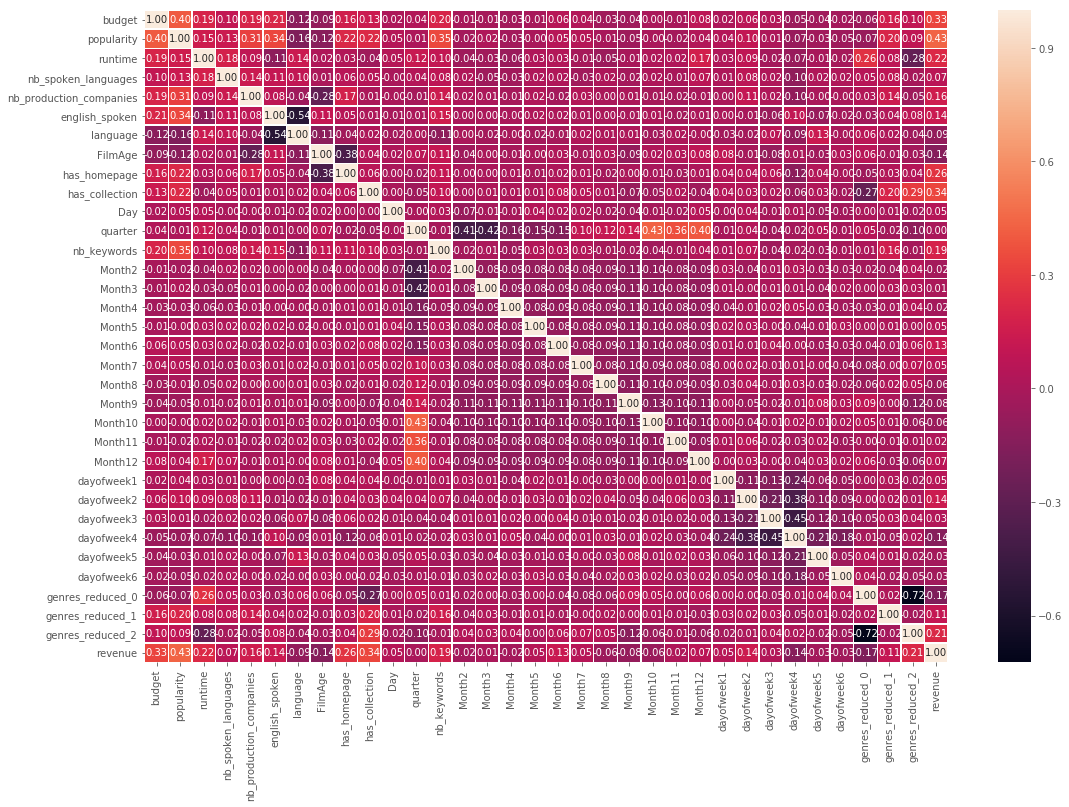

In [106]:
X['revenue'] = train.revenue
f,ax = plt.subplots(figsize=(18, 12))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

In [107]:
X.columns

Index(['budget', 'popularity', 'runtime', 'nb_spoken_languages',
       'nb_production_companies', 'english_spoken', 'language', 'FilmAge',
       'has_homepage', 'has_collection', 'Day', 'quarter', 'nb_keywords',
       'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7', 'Month8',
       'Month9', 'Month10', 'Month11', 'Month12', 'dayofweek1', 'dayofweek2',
       'dayofweek3', 'dayofweek4', 'dayofweek5', 'dayofweek6',
       'genres_reduced_0', 'genres_reduced_1', 'genres_reduced_2', 'revenue'],
      dtype='object')

We normalize the data for having a reduced spectre

In [108]:
X = X.drop(['revenue'], axis = 1)
y = train.revenue.apply(np.log1p)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Lbm parameters

In [109]:
params = {'objective': 'reg:linear', 
           'eta': 0.01, 
          'max_depth': 6, 
          'subsample': 0.7, 
          'colsample_bytree': 0.8,
           'gamma': 1.45, 
          'eval_metric': 'rmse', 
          'seed': 12, 
          'silent': True    
}

In [110]:
# create dataset for xgboost

xgb_data = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]

In [111]:
print('Starting training...')
# train
xgb_model = xgb.train(params, 
                  xgb.DMatrix(X_train, y_train),
                  5000,  
                  xgb_data, 
                  verbose_eval=200,
                  early_stopping_rounds=200)

Starting training...
[0]	train-rmse:15.691	valid-rmse:15.3788
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[200]	train-rmse:2.6854	valid-rmse:2.89954
[400]	train-rmse:1.35894	valid-rmse:2.08244
[600]	train-rmse:1.17019	valid-rmse:2.06415
[800]	train-rmse:1.05772	valid-rmse:2.06111
[1000]	train-rmse:0.953387	valid-rmse:2.05985
Stopping. Best iteration:
[925]	train-rmse:0.990873	valid-rmse:2.05759



### Catboost

In [112]:
catmodel = catb.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.7,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=12)

In [113]:
ti=time.time()
catmodel.fit(X, y, 
             eval_set=(X_train, y_train), 
             verbose=500, 
             use_best_model=True)

print("Number of minutes of training of model_cal = {:.2f}".format((time.time()-ti)/60))

cat_pred_train=catmodel.predict(X)
cat_pred_train[cat_pred_train<0]=0

0:	learn: 16.1185365	test: 16.1809970	best: 16.1809970 (0)	total: 20ms	remaining: 3m 19s
500:	learn: 2.0088724	test: 1.9899553	best: 1.9899553 (500)	total: 14.8s	remaining: 4m 40s
1000:	learn: 1.8938822	test: 1.8673554	best: 1.8673554 (1000)	total: 27.7s	remaining: 4m 9s
1500:	learn: 1.8160314	test: 1.7827540	best: 1.7827540 (1500)	total: 40.8s	remaining: 3m 50s
2000:	learn: 1.7774174	test: 1.7415256	best: 1.7415256 (2000)	total: 53.1s	remaining: 3m 32s
2500:	learn: 1.7487928	test: 1.7112214	best: 1.7112214 (2500)	total: 1m 4s	remaining: 3m 14s
3000:	learn: 1.7084277	test: 1.6688625	best: 1.6688625 (3000)	total: 1m 18s	remaining: 3m 3s
3500:	learn: 1.6774171	test: 1.6365662	best: 1.6365662 (3500)	total: 1m 32s	remaining: 2m 51s
4000:	learn: 1.6556660	test: 1.6141183	best: 1.6141183 (4000)	total: 1m 47s	remaining: 2m 41s
4500:	learn: 1.6340102	test: 1.5915294	best: 1.5915294 (4500)	total: 2m 4s	remaining: 2m 31s
5000:	learn: 1.6196453	test: 1.5763793	best: 1.5763793 (5000)	total: 2m 16s

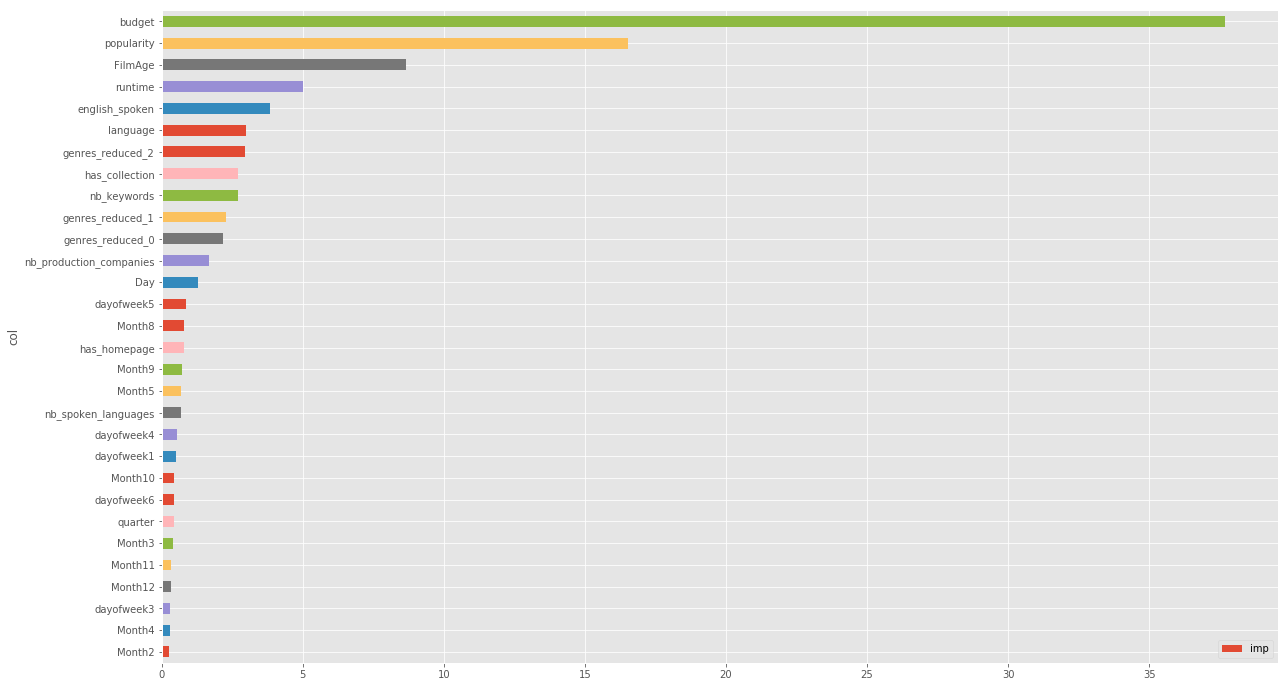

In [114]:
# Feature Importance CATB
fea_imp = pd.DataFrame({'imp': catmodel.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 12))
plt.savefig('catboost_feature_importance.png')   

#### Feature Importance

<Figure size 1080x1080 with 0 Axes>

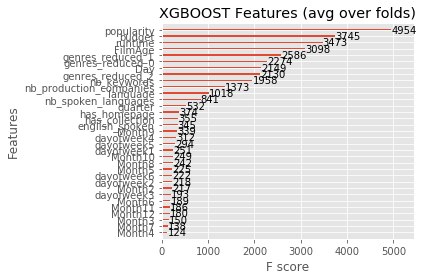

In [115]:
plt.figure(figsize=(15, 15))
xgb.plot_importance(xgb_model)
#sns.barplot(x="Value", y="Feature", data=importance)#.sort_values(by="Value", ascending=False))
plt.title('XGBOOST Features (avg over folds)')
plt.tight_layout()
plt.show()

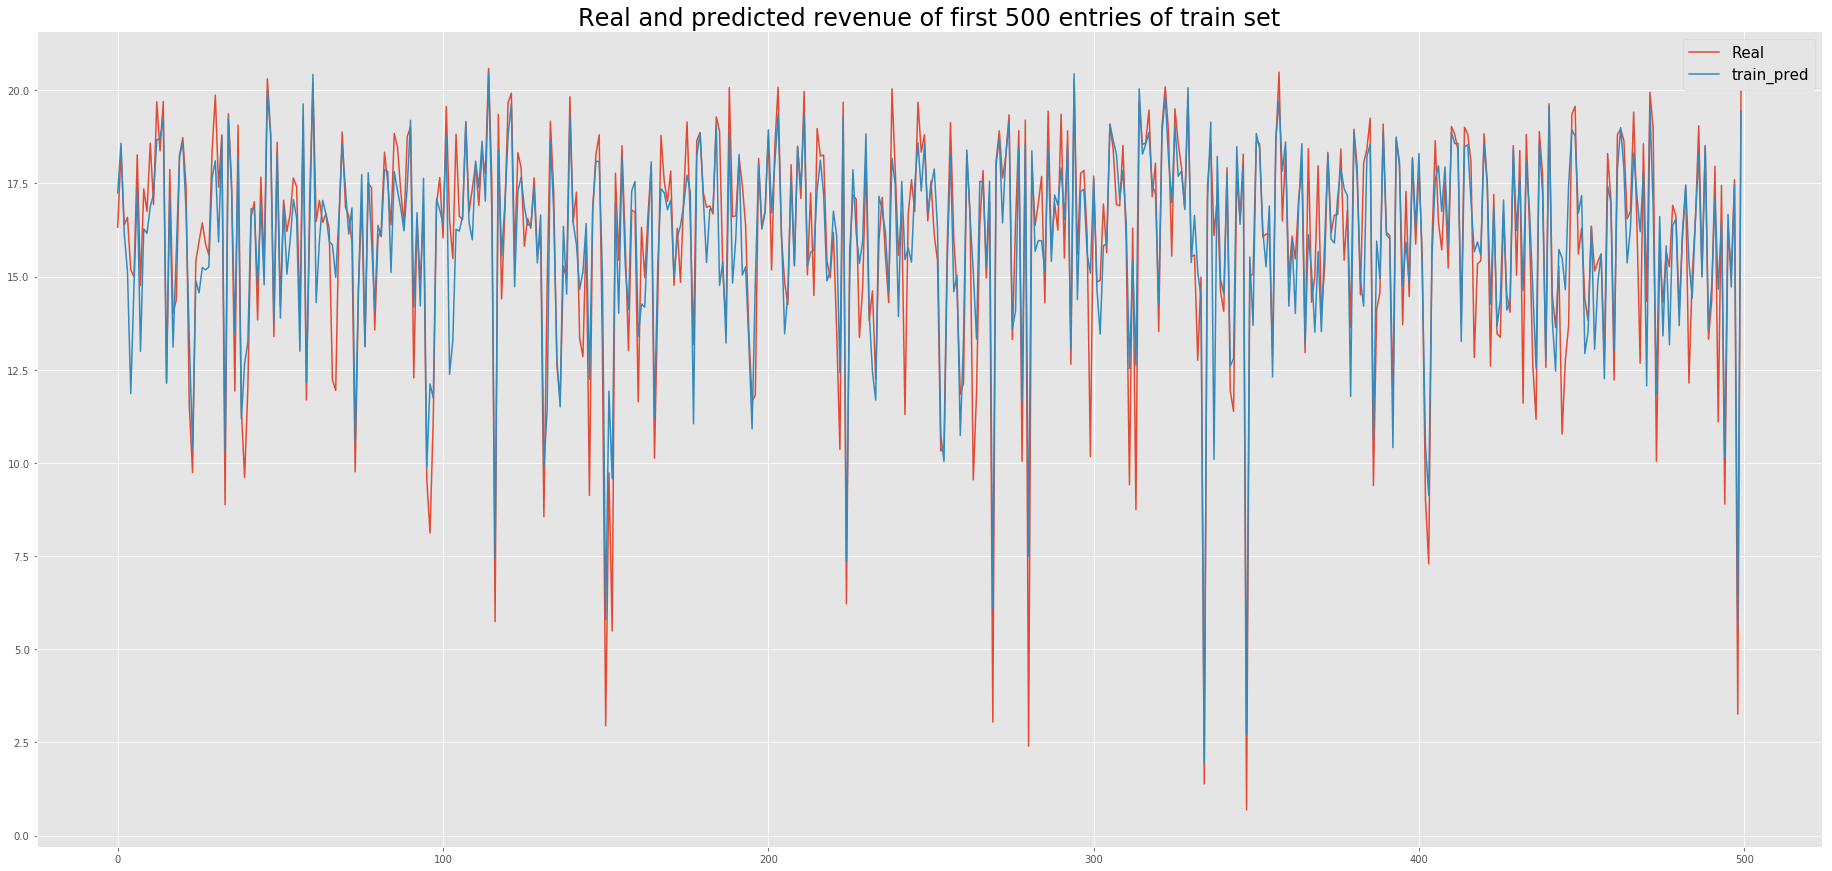

In [116]:
train_pred = xgb_model.predict(xgb.DMatrix(X), ntree_limit=xgb_model.best_ntree_limit)
plt.figure(figsize=(32,15))
plt.plot(y[:500],label="Real")
plt.plot(train_pred[:500],label="train_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()

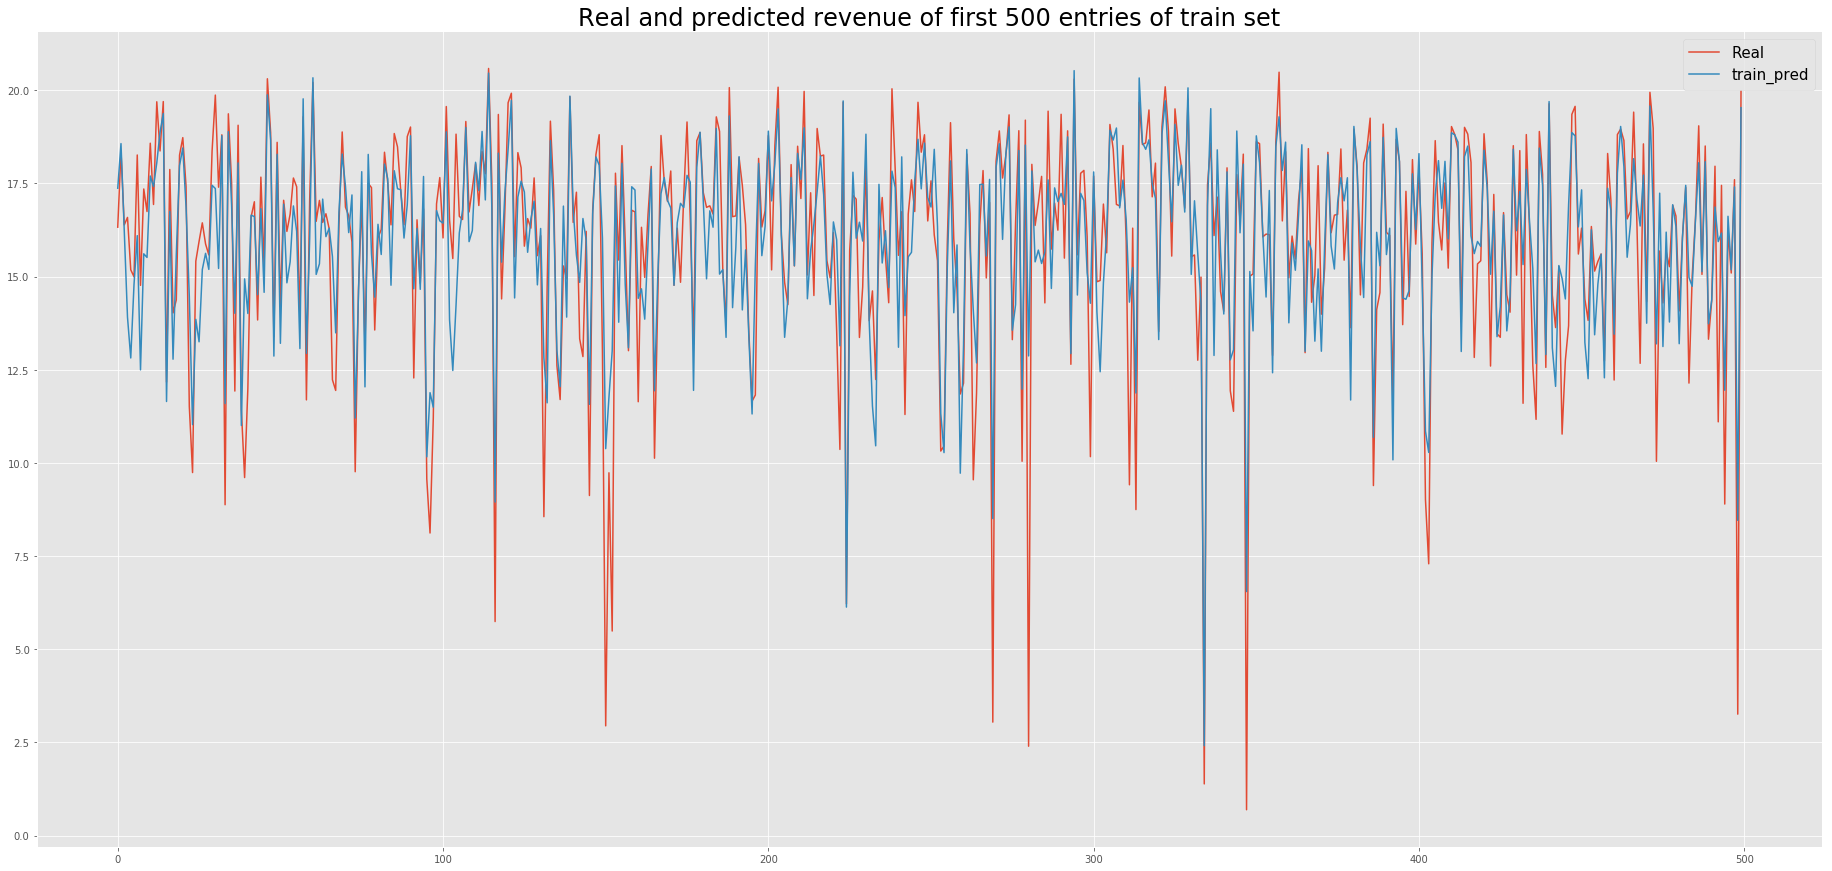

In [117]:
plt.figure(figsize=(32,15))
plt.plot(y[:500],label="Real")
plt.plot(cat_pred_train[:500],label="train_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()

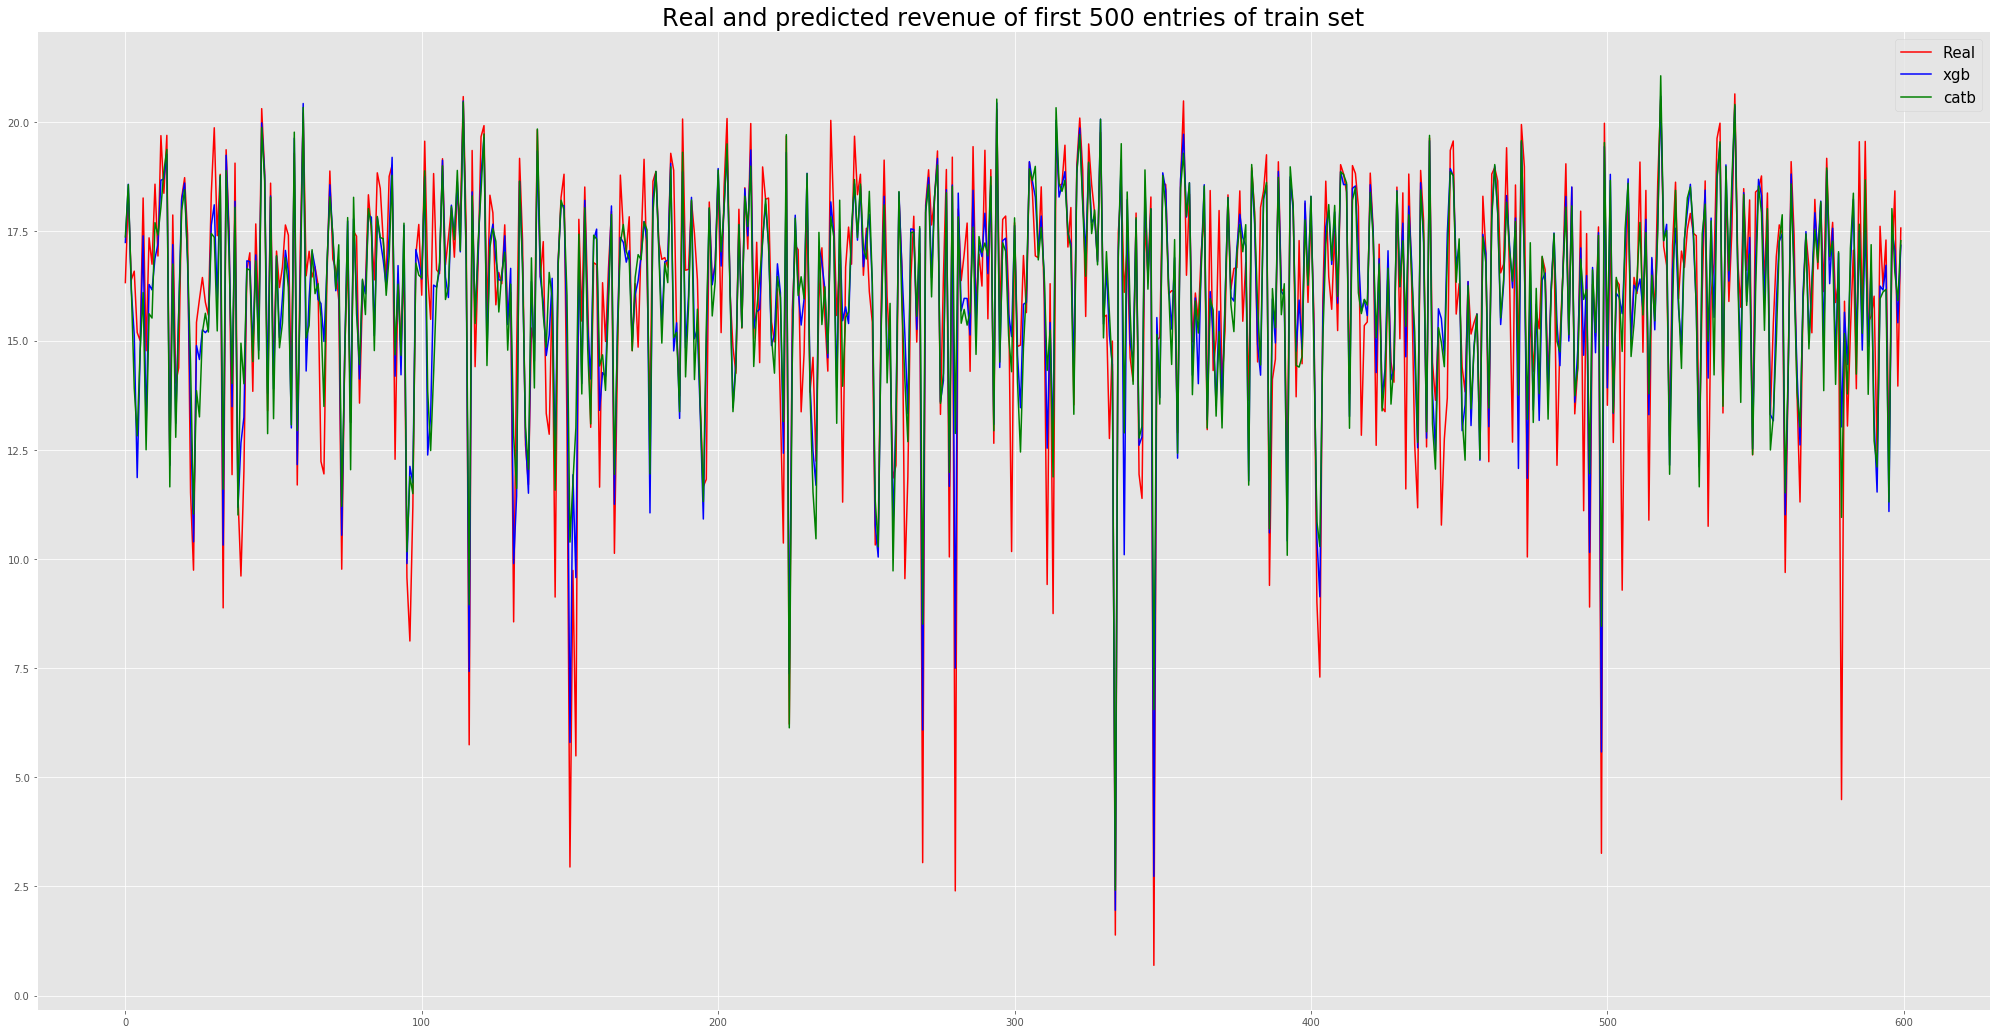

In [118]:
plt.figure(figsize=(35,18))
plt.plot(y[:600],label="Real", color = "red")
plt.plot(xgb_model.predict(xgb.DMatrix(X), ntree_limit=xgb_model.best_ntree_limit)[:600],label="xgb", color = "blue")
plt.plot(cat_pred_train[:600],label="catb", color = "green")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()

### Export

#### XGB

In [119]:
X_test = test[features]
xgb_pred = np.expm1(xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit))
pd.DataFrame({'id': test.id, 'revenue': xgb_pred}).to_csv('Output/xgbsubmission27.csv', index=False)

In [120]:
xgb_pred[0]

14182640.0

#### CATB

In [121]:
X_test = test[features]
catb_pred = np.expm1(catmodel.predict(X_test.values))
pd.DataFrame({'id': test.id, 'revenue': catb_pred}).to_csv('Output/catbsubmission29.csv', index=False)

In [122]:
catb_pred[0]

11501162.109043242

### Ensemble

In [123]:
ens_pred = 0.4*xgb_pred + 0.6*catb_pred
pd.DataFrame({'id': test.id, 'revenue': ens_pred}).to_csv('Output/enssubmission30.csv', index=False)

In [124]:
ens_pred[0]

12573753.265425947

---

In [125]:
pd.DataFrame({'id': test.id, 'revenue': ens_pred}).head()

,id,revenue
0,3001,1.257375e+07
1,3002,1.565253e+06
2,3003,6.919222e+06
3,3004,6.814763e+06
4,3005,2.619639e+05
